In [ ]:
import os
import cv2
import torch
import shutil
import torchvision
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.utils import resample
from IPython.display import display
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

##### Read csv file

In [ ]:
# read csv file
data = pd.read_csv('Chest_xray_Corona_Metadata.csv')
meta = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')

In [ ]:
display(data)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [ ]:
display(meta)

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


##### Plot dataset distribution

In [ ]:
# data = data.fillna('missing')

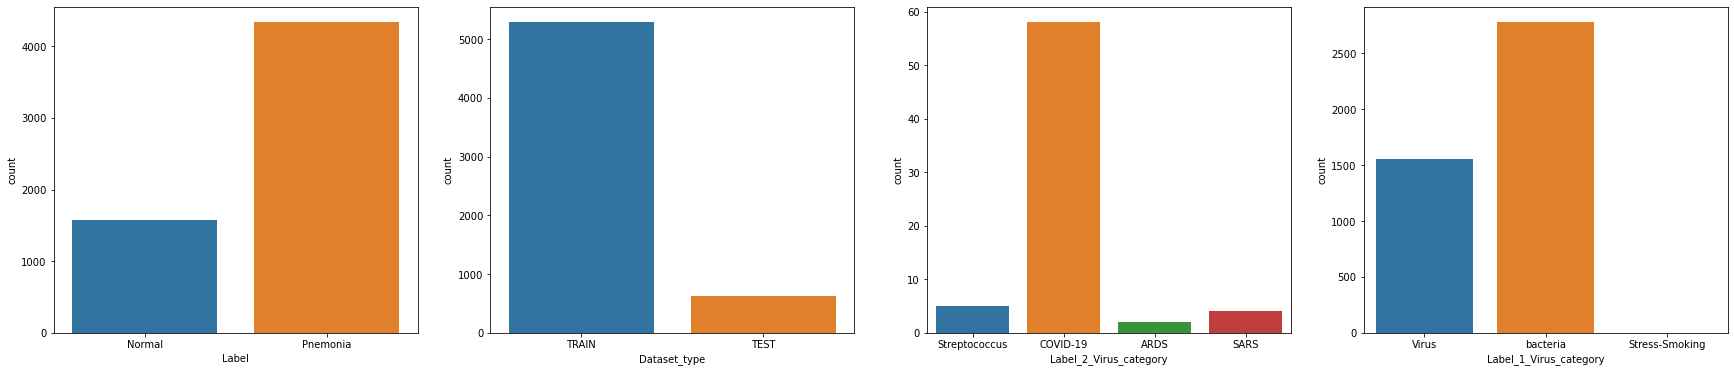

In [ ]:
# general data distribution
category = ['Label', 'Dataset_type', 'Label_2_Virus_category', 'Label_1_Virus_category']

fig, axs = plt.subplots(1, 4, figsize=(30, 6))
for i in range(len(category)):
    sn.countplot(x = data[category[i]], ax = axs[i])

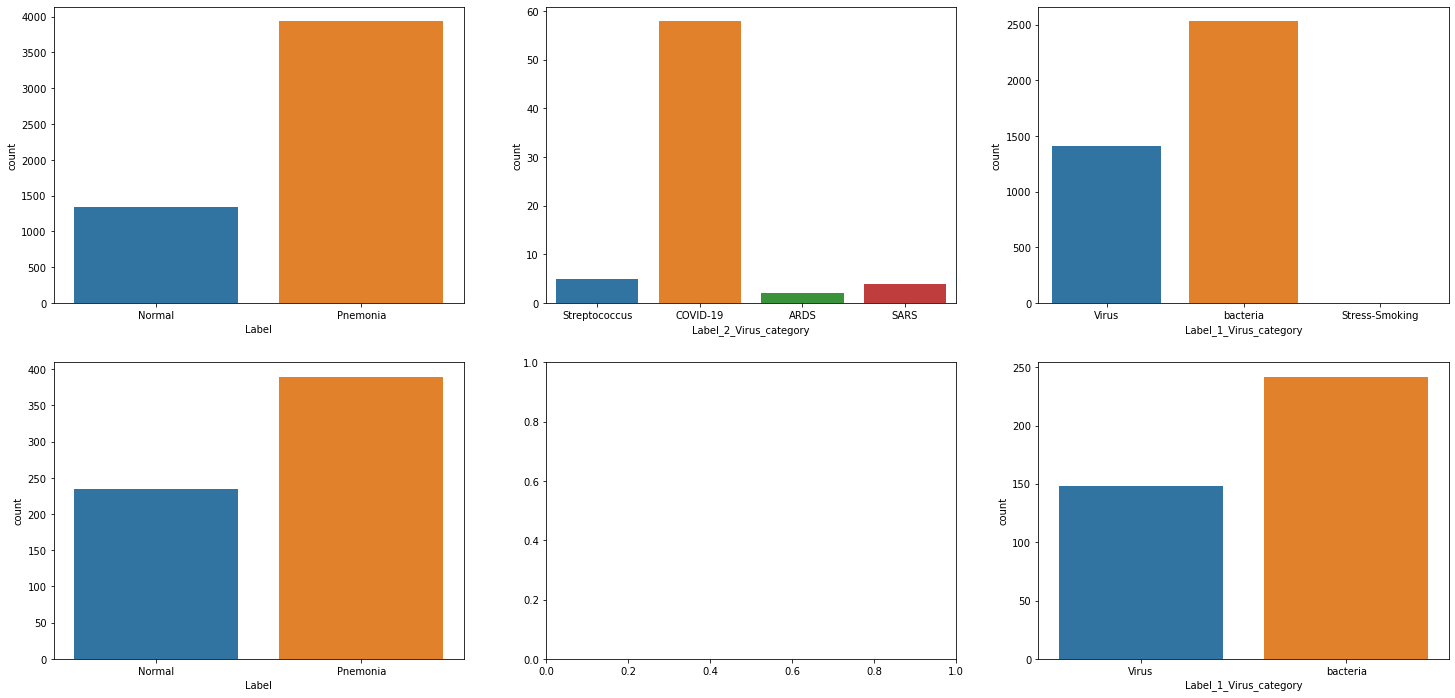

In [ ]:
# train test data distribution
set_type = ['TRAIN', 'TEST']
category = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
for i in range(len(set_type)):
    for j in range(len(category)):
        try:
            sn.countplot(x = data[data['Dataset_type'] == set_type[i]][category[j]], ax = axs[i][j])
        except ValueError:
            pass

##### As a result of the visualization, it was determined that there was no COVID-19 image in the test data. In order to correct this situation, it was decided to move some covid-19 images in the training set.

# 1) Data Preprocessing

In [ ]:
# find the size of the COVID-19 image count and get %25 of them
train_c19_count = len(list(data[data.Label_2_Virus_category == 'COVID-19'].X_ray_image_name))

split_rate = 0.25
test_c19_count = int(train_c19_count * split_rate)

test_c19_name = list(data[data.Label_2_Virus_category == 'COVID-19'].X_ray_image_name[-test_c19_count : ])

In [ ]:
# change covid19 dataset_type train to test
for index, row in data.iterrows():
    if row['X_ray_image_name'] in test_c19_name:
        data.at[index, 'Dataset_type'] = 'TEST'

### Important: Classification will be made over three types. It is Normal, Pnemonia and Covid-19.

In [ ]:
# change pnemonia label to covid-19 if Label_2_Virus_category is Covid-19
for index, row in data.iterrows():
    if row['Label_2_Virus_category'] == 'COVID-19':
        data.at[index, 'Label'] = 'COVID-19'

In [ ]:
base_path = 'Coronahack-Chest-XRay-Dataset'
test_path = 'test'
train_path = 'train'

In [ ]:
# move covid-19 images train to test
# prevent runnning each iteration. If you want to use please uncomment code snippet.
for img in test_c19_name:
    src = os.path.join(base_path, train_path, img)
    dst = os.path.join(base_path, test_path)
    shutil.move(src, dst)

##### Last dataset distribution

In [ ]:
last = data.groupby('Dataset_type')['Label'].value_counts()

<AxesSubplot:xlabel='Label'>

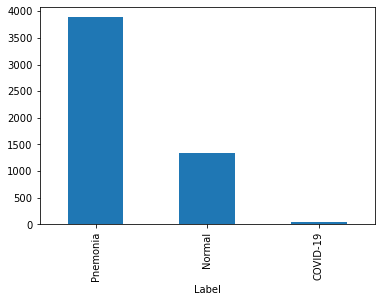

In [ ]:
last['TRAIN'].plot.bar()

<AxesSubplot:xlabel='Label'>

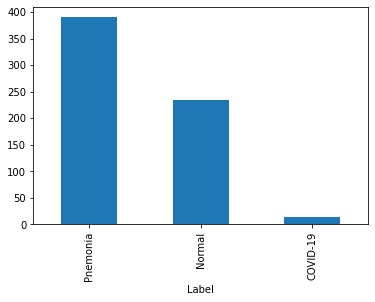

In [ ]:
last['TEST'].plot.bar()

##### Research has been done on the data set. As a result of this research, it was found that some images in the data set are not in the csv file.

In [ ]:
f_train_img_names = os.listdir(os.path.join(base_path, train_path))
f_test_img_names = os.listdir(os.path.join(base_path, test_path))

In [ ]:
# get image names from csv file
c_train_img_names = list(data[data['Dataset_type'] == 'TRAIN']['X_ray_image_name'])
c_test_img_names = list(data[data['Dataset_type'] == 'TEST']['X_ray_image_name'])

In [ ]:
# This function is used to check missing images
# f_img_names: folder image names
# c_img_names: csv image names
# return missing_img_names: missing image names
def check_img_names(f_img_names, c_img_names):
    missing_img_names = []
    for img_name in f_img_names:
        if img_name not in c_img_names:
            missing_img_names.append(img_name)
    return missing_img_names

In [ ]:
# This function is used to missing images
# path: image base path
# missing_img_names: missing image names
def remove_missing_imgs(path, missing_img_names):
    for img_name in missing_img_names:
        os.remove(os.path.join(path, img_name))

In [ ]:
missing_train_img_names = check_img_names(f_train_img_names, c_train_img_names)
remove_missing_imgs(os.path.join(base_path, train_path), missing_train_img_names)

missing_test_img_names = check_img_names(f_test_img_names, c_test_img_names)
remove_missing_imgs(os.path.join(base_path, test_path), missing_test_img_names)

##### Visualize some image

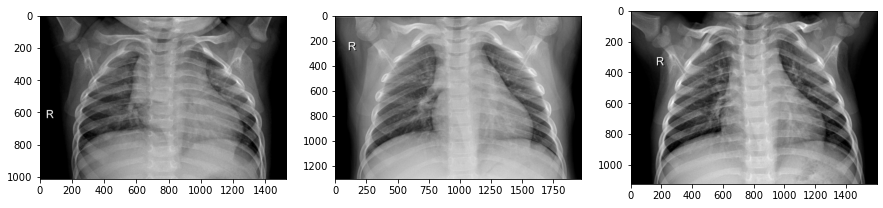

In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    img_name = data.iloc[i]['X_ray_image_name']
    img = cv2.imread(os.path.join(base_path, train_path, img_name))
    
    ax[i].imshow(img)

### * Up-sample minority class. 
### * Relevant images have been saved for later use. It is sufficient to run this part once.

In [ ]:
# initial data distribution
data.groupby('Dataset_type')['Label'].value_counts()['TRAIN']

Label
Pnemonia    3886
Normal      1342
COVID-19      44
Name: Label, dtype: int64

In [ ]:
# This function is used to read image using opencv
# base_path: image root path
# img_names: image name list
# return img_array: includes pixel values of image.
def read_img(base_path, img_names):
    img_array = []
    for img_name in img_names:
        img = cv2.imread(os.path.join(base_path, img_name), cv2.IMREAD_GRAYSCALE)
        img_array.append(cv2.resize(img, (256, 256)))
    return img_array

In [ ]:
test_data = data[data['Dataset_type'] == 'TEST']
train_data = data[data['Dataset_type'] == 'TRAIN']

In [ ]:
test_img_names = test_data['X_ray_image_name']
train_img_names = train_data['X_ray_image_name']

In [ ]:
x_test = np.array(read_img(os.path.join(base_path, test_path), test_img_names)).reshape(-1, 256 * 256).astype('int16')
x_train = np.array(read_img(os.path.join(base_path, train_path), train_img_names)).reshape(-1, 256 * 256).astype('int16')

In [ ]:
y_test = test_data.Label.map({'Normal':0, 'Pnemonia':1, 'COVID-19':2})
y_train = train_data.Label.map({'Normal':0, 'Pnemonia':1, 'COVID-19':2})

In [ ]:
y_test.index = np.arange(0, len(y_test))
test_sample = pd.DataFrame(x_test)
test_sample['label'] = y_test

train_sample = pd.DataFrame(x_train)
train_sample['label'] = y_train

In [ ]:
normal_sample = train_sample[train_sample.label == 0]
pnemonia_sample = train_sample[train_sample.label == 1]
covid19_sample = train_sample[train_sample.label == 2]

In [ ]:
max_num = max(len(normal_sample), len(pnemonia_sample), len(covid19_sample))

In [ ]:
normal_resampled = resample(normal_sample, replace = True, n_samples = max_num)
pnemonia_resampled = resample(pnemonia_sample, replace = True, n_samples = max_num)
covid19_resampled = resample(covid19_sample, replace = True, n_samples = max_num)

In [ ]:
path = 'dataset'
data_types = ['train', 'valid', 'test']
categories = ['normal', 'pnemonia', 'covid-19']

In [ ]:
# create root folder
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)

In [ ]:
# create sub folder
for data_type in data_types:
    data_type_path = os.path.join(path, data_type)
    os.makedirs(data_type_path)
    for category in categories:
        category_path = os.path.join(data_type_path, category)
        os.makedirs(category_path)

In [ ]:
split_ratio = 0.15

In [ ]:
normal_test = test_sample[test_sample.label == 0]
pnemonia_test = test_sample[test_sample.label == 1]
covid19_test = test_sample[test_sample.label == 2]

In [ ]:
normal_train, normal_valid = normal_resampled[:max_num - int(max_num * split_ratio)], normal_resampled[max_num - int(max_num * split_ratio):]
pnemonia_train, pnemonia_valid = pnemonia_resampled[:max_num - int(max_num * split_ratio)], pnemonia_resampled[max_num - int(max_num * split_ratio):]
covid19_train, covid19_valid = covid19_resampled[:max_num - int(max_num * split_ratio)], covid19_resampled[max_num - int(max_num * split_ratio):]

In [ ]:
last_train = [normal_train, pnemonia_train, covid19_train]
last_valid = [normal_valid, pnemonia_valid, covid19_valid]
last_test = [normal_test, pnemonia_test, covid19_test]

In [ ]:
last_data = [last_train, last_valid, last_test]

In [ ]:
for data_type, data in zip(data_types, last_data):
    for category, category_data in zip(categories, data):
        i = 0
        category_data = np.array(category_data.drop('label', axis=1))
        category_data = category_data.reshape(-1, 256, 256)
        for img in category_data:
            file_path = os.path.join(path, data_type, category, str(i) + '.jpg')
            cv2.imwrite(file_path, img) 
            i += 1

## Classification Part

In [ ]:
nb_classes = 3
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, nb_classes)

In [ ]:
is_cpu_available = torch.cuda.is_available()

In [ ]:
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001, weight_decay=0.001)
criteria = nn.CrossEntropyLoss()
n_epochs = 8

In [ ]:
train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('./dataset/train', train_transforms)
val_dataset = ImageFolder('./dataset/valid', val_transforms)
test_dataset = ImageFolder('./dataset/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)

classes = ['Normal', 'pnemonia', 'Covid-19']

In [ ]:
resnet18.train()

if is_cpu_available:
    resnet18.cuda()
    criteria.cuda()

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(train_loader):
        resnet18.zero_grad()
        
        img, label = data
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()

        # Forward pass
        outputs = resnet18.forward(img)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        resnet18.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(val_loader):
            img, label = data

            if is_cpu_available:
                img = img.cuda()
                label = label.cuda()

            # Test forward
            outputs = resnet18.forward(img)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    resnet18.train()
    
writer.close()

Epoch: 0 - Train Loss: 0.06499676685329647 - Train Accuracy: 0.9778046607971191
Epoch: 0 - Val Loss: 0.021093322718727655 - Val Accuracy: 0.9925544857978821
Epoch: 1 - Train Loss: 0.010397290767193021 - Train Accuracy: 0.996569812297821
Epoch: 1 - Val Loss: 0.012538953999253201 - Val Accuracy: 0.9959908723831177
Epoch: 2 - Train Loss: 0.005250740389155614 - Train Accuracy: 0.9985875487327576
Epoch: 2 - Val Loss: 0.011676924873873677 - Val Accuracy: 0.9948453903198242
Epoch: 3 - Train Loss: 0.005098472875561716 - Train Accuracy: 0.9981839656829834
Epoch: 3 - Val Loss: 0.014371375612542828 - Val Accuracy: 0.9959908723831177
Epoch: 4 - Train Loss: 0.006169944367701969 - Train Accuracy: 0.9984866380691528
Epoch: 4 - Val Loss: 0.013393432552733099 - Val Accuracy: 0.9971363544464111
Epoch: 5 - Train Loss: 0.007710302250756461 - Train Accuracy: 0.9973768591880798
Epoch: 5 - Val Loss: 0.04205464357267126 - Val Accuracy: 0.9856815934181213
Epoch: 6 - Train Loss: 0.007912049577721665 - Train Acc

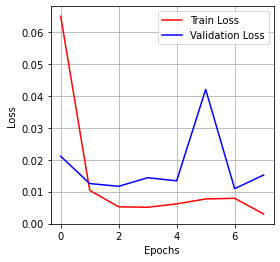

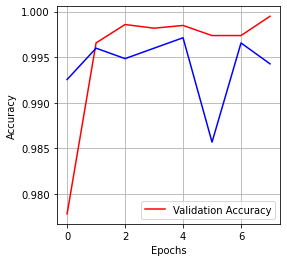

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Test Accuracy: % 0.869905948638916 


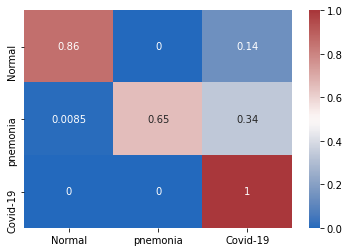

In [ ]:
resnet18.eval()

targets = []
predicts = []

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        img, label = data
        
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()
        
        outputs = resnet18.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)
        
        preds = predictions.detach().cpu().numpy()
        labels = label.detach().cpu().numpy()
        
        for i in range(len(preds)):
            targets.append(labels[i])
            predicts.append(preds[i])

    print('Test Accuracy: % {} '.format(correct_prediction / total))
    
    matrix = confusion_matrix(targets, predicts, normalize = 'true')
    sn.heatmap(matrix, annot=True, cmap = sn.color_palette("vlag", as_cmap=True), xticklabels=classes, yticklabels=classes)

In [ ]:
class OurModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        pass
        #self.seq = nn.Sequential(nn.Linear(10,10))


        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer1[0].weight)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
           # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer2[0].weight)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          #  nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer3[0].weight)
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer4[0].weight)
        
        self.fc1 = nn.Linear(7 * 7 * 256, 1024)
        self.dr1 = nn.Dropout(p = 0.25)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 3)


    def forward(self, x):
        # TO DO: Your neural network design
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = out.reshape(out.size(0), -1) # flatten layer
        out = torch.nn.functional.relu(self.fc1(out))
        out = self.dr1(out)
        out = self.fc2(out)
        return out

model = OurModel()